# Week 4 – Sequential Models: LSTMs (PyTorch)

This notebook covers sequence models in deep learning, focusing on **RNNs** and **LSTMs**. We will work with both **text data (IMDB)** and **time series data (Airline Passengers)** to understand how sequential data is handled.

---

## 1. Sequence Data Types (1h)

Sequences are ordered data where the position of each element matters. Examples:
- **Text**: Words in a sentence, characters in a word.
- **Time series**: Stock prices, monthly airline passengers, temperature.

In PyTorch, sequences are typically represented as tensors of shape `(seq_len, batch, features)`.

---

## 2. RNNs vs LSTMs (1.5h)

### Intuition:

- **RNN (Recurrent Neural Network)**: Maintains a hidden state that gets updated with each element in the sequence.  
  Problem: **Vanishing gradient** for long sequences.

- **LSTM (Long Short-Term Memory)**: Special type of RNN with gates (input, forget, output) to maintain long-term dependencies.

In [4]:
import torch
import torch.nn as nn

# Example sequence: batch_size=2, sequence_length=3, features=4
x = torch.randn(3, 2, 4)  # (seq_len, batch, input_size)

# Simple RNN
rnn = nn.RNN(input_size=4, hidden_size=5, num_layers=1)
out_rnn, h_n_rnn = rnn(x)
print("RNN output shape:", out_rnn.shape)
print("RNN hidden state shape:", h_n_rnn.shape)

print("____________________________________")

# LSTM
lstm = nn.LSTM(input_size=4, hidden_size=5, num_layers=1)
out_lstm, (h_n_lstm, c_n_lstm) = lstm(x)
print("LSTM output shape:", out_lstm.shape)
print("LSTM hidden state shape:", h_n_lstm.shape)
print("LSTM cell state shape:", c_n_lstm.shape)

RNN output shape: torch.Size([3, 2, 5])
RNN hidden state shape: torch.Size([1, 2, 5])
____________________________________
LSTM output shape: torch.Size([3, 2, 5])
LSTM hidden state shape: torch.Size([1, 2, 5])
LSTM cell state shape: torch.Size([1, 2, 5])


## LSTM Demo: Time Series Forecasting (Airline Passengers)

![Airline Passengers](https://media.cnn.com/api/v1/images/stellar/prod/240124120208-08-unruly-passengers.jpg?c=16x9&q=h_653,w_1160,c_fill/f_avif)

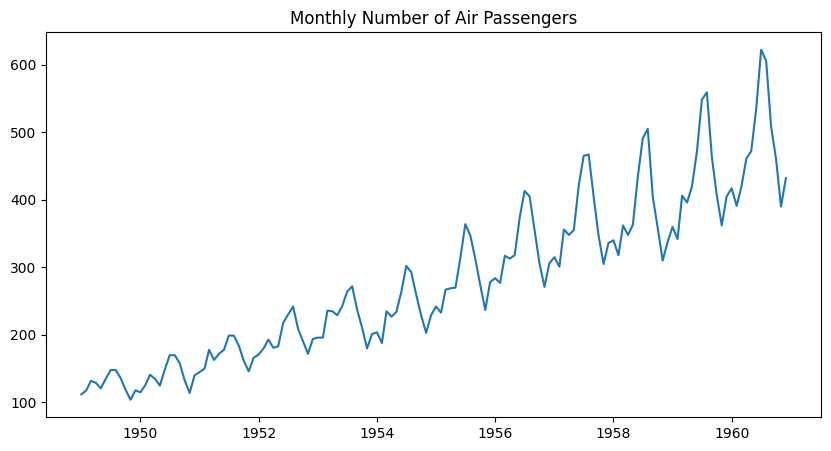

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# ---------------------
# 1. Load Dataset
# ---------------------
df = pd.read_csv('AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)


plt.figure(figsize=(10,5))
plt.plot(df['Passengers'])
plt.title('Monthly Number of Air Passengers')
plt.show()

In [17]:
# ---------------------
# 2. Data Preprocessing
# ---------------------
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df['Passengers'].values.reshape(-1,1))

# Split into train and test (80% train, 20% test)
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size - 12:] # Include sequence overlap for LSTM


# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
        
    return np.array(xs), np.array(ys)


SEQ_LENGTH = 12
X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)


# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [18]:
# ---------------------
# 3. Define LSTM Model
# ---------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 20/200, Loss: 0.0028
Epoch 40/200, Loss: 0.0044
Epoch 60/200, Loss: 0.0037
Epoch 80/200, Loss: 0.0062
Epoch 100/200, Loss: 0.0067
Epoch 120/200, Loss: 0.0065
Epoch 140/200, Loss: 0.0013
Epoch 160/200, Loss: 0.0011
Epoch 180/200, Loss: 0.0005
Epoch 200/200, Loss: 0.0002


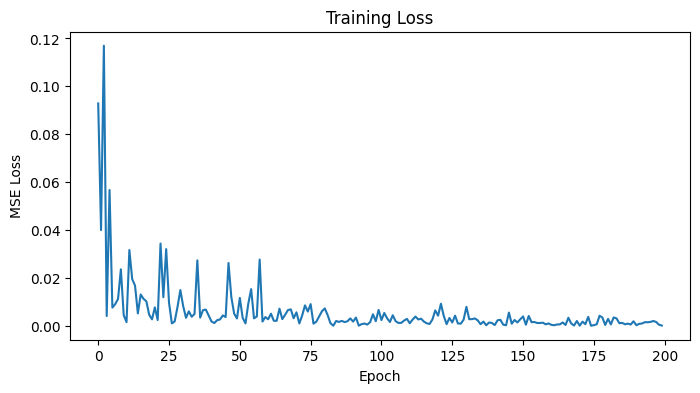

In [19]:
# ---------------------
# 4. Train the model
# ---------------------
NUM_EPOCHS = 200
losses = []

for epoch in range(NUM_EPOCHS):
    for seq, target in dataloader:
        optimizer.zero_grad()
        
        output = model(seq)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
    losses.append(loss.item())
        
    if (epoch+1) % 20 == 0:
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss.item():.4f}')


# Plot training loss
plt.figure(figsize=(8,4))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

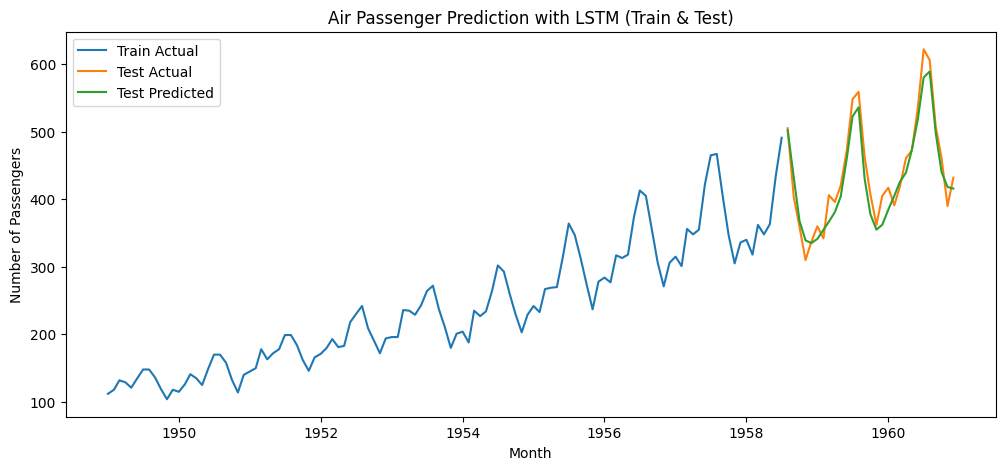

In [28]:
# ---------------------
# 5. Make Predictions on Test Data
# ---------------------
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train).numpy()
    y_test_pred = model(X_test).numpy()


# Rescale back to original values
train_data_rescaled = scaler.inverse_transform(train_data.reshape(-1,1))
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_test_true_rescaled = scaler.inverse_transform(y_test.numpy().reshape(-1,1))


# ---------------------
# 6. Visualize Train and Test Predictions
# ---------------------
plt.figure(figsize=(12,5))


# Plot train data
plt.plot(df.index[:train_size], train_data_rescaled, label='Train Actual')


# Plot test data
plt.plot(df.index[train_size:], y_test_true_rescaled, label='Test Actual')
plt.plot(df.index[train_size:], y_test_pred_rescaled, label='Test Predicted')


plt.title('Air Passenger Prediction with LSTM (Train & Test)')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

## Historical Data AAPL

(2514, 1)
Epoch 20, Loss: 0.0121
Epoch 40, Loss: 0.0012
Epoch 60, Loss: 0.0003
Epoch 80, Loss: 0.0003
Epoch 100, Loss: 0.0003


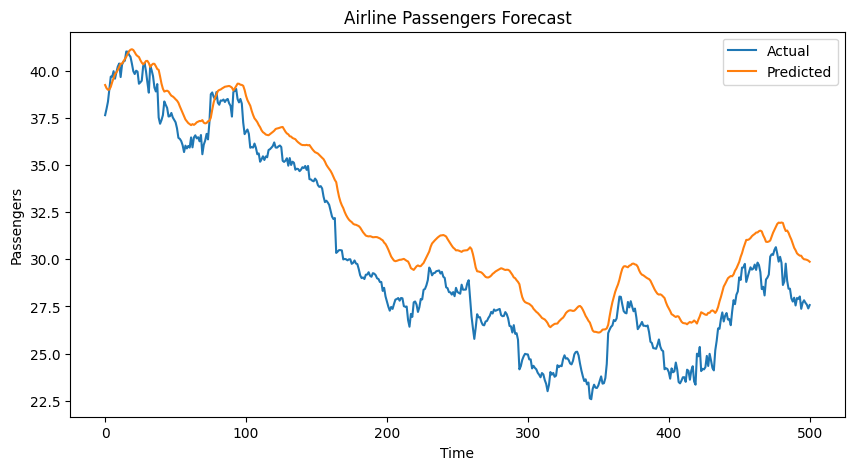

In [30]:
import pandas as pd
import numpy as np
import torch.nn as nn

# For demo purposes, let's use Apple (AAPL) stock prices from Yahoo Finance
# You can replace this with your CSV file
url = 'HistoricalData.csv'
df = pd.read_csv(url, usecols=['Date','Close'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Keep only closing prices
data = df['Close'].values.reshape(-1,1).astype('float32')

print(data.shape)

# Normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length=12):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12
X, y = create_sequences(data, seq_length)
X = torch.tensor(X).float()
y = torch.tensor(y).float()

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# LSTM model
class LSTMTimeSeries(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

input_dim = 1
hidden_dim = 50
output_dim = 1

model = LSTMTimeSeries(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Reshape for LSTM: (batch, seq_len, features)
X_train = X_train.view(-1, seq_length, 1)
X_test = X_test.view(-1, seq_length, 1)

# Training loop
model.train()
for epoch in range(100):  # demo: 100 epochs
    optimizer.zero_grad()
    
    output = model(X_train)
    loss = criterion(output, y_train)
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Forecast
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Inverse transform
y_pred = scaler.inverse_transform(y_pred.numpy())
y_test_inv = scaler.inverse_transform(y_test.numpy())

# Plot
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Airline Passengers Forecast')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.show()

# Falar do drift
